In [6]:
import os
import json
import pdfplumber
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string
import spacy
from spacy import displacy
from spacy.lang.en.examples import sentences 
import random
import pickle
from lexicalrichness import LexicalRichness

%matplotlib inline

In [2]:
with open('data/gpt4_speakers_recipients_processed.json', 'r') as outfile:
    speakers = pd.read_json(outfile)

In [3]:
# male_spoken_words = ' '.join(speakers[speakers.gender_recipient == 'M'].spoken_words_only)
# female_spoken_words = ' '.join(speakers[speakers.gender_recipient == 'F'].spoken_words_only)
# ngs_spoken_words = ' '.join(speakers[speakers.gender_recipient == 'NGS'].spoken_words_only)

male_spoken_words = ' '.join(speakers[speakers.gender_speaker == 'M'].spoken_words_only)
female_spoken_words = ' '.join(speakers[speakers.gender_speaker == 'F'].spoken_words_only)
ngs_spoken_words = ' '.join(speakers[speakers.gender_speaker == 'NGS'].spoken_words_only)

In [91]:
len((female_spoken_words + male_spoken_words + ngs_spoken_words).split())

32324

In [4]:
len(female_spoken_words.split())

7816

In [5]:
sum([len(text.split()) for text in speakers[speakers.gender_speaker=='F'].spoken_words_only])

7816

#### For interview:

In [9]:
import sqlite3

In [10]:
conn = sqlite3.connect('character_database.db')

In [11]:
aliases = pd.read_sql('select * from aliases', conn, index_col='index')
characters = pd.read_sql('select * from characters', conn, index_col='index')

In [12]:
remove_non_stories = [
    'All Year Round', 'All About Feelings', 'Ten in the Bed and Other Counting Rhymes', 'Why Am I An Insect',
    'Farmer Duck'
]

In [13]:
characters = characters[~characters.book.isin(remove_non_stories)]

In [14]:
gender_count = {
    G: sum([1 for g in characters.gender if g==G])
    for G in ['F', 'M', 'NGS']
}

In [15]:
human_count = {
    G: sum([1 for g,h in zip(characters.gender, characters.human) if g==G and h=='H'])
    for G in ['F', 'M', 'NGS']
}

In [16]:
human_count

{'F': 197, 'M': 223, 'NGS': 59}

In [17]:
nonhuman_count = {
    G: sum([1 for g,h in zip(characters.gender, characters.human) if g==G and h=='NH'])
    for G in ['F', 'M', 'NGS']
}

In [18]:
nonhuman_count

{'F': 123, 'M': 271, 'NGS': 516}

In [19]:
protagonist_count = {
    G: sum([1 for g,h in zip(characters.gender, characters.is_protagonist) if g==G and h==1])
    for G in ['F', 'M', 'NGS']
}

In [20]:
protagonist_count

{'F': 44, 'M': 142, 'NGS': 21}

In [21]:
secondary_count = {
    G: sum([1 for g,h in zip(characters.gender, characters.is_protagonist) if g==G and h==0])
    for G in ['F', 'M', 'NGS']
}

In [22]:
secondary_count

{'F': 286, 'M': 388, 'NGS': 580}

In [23]:
secondary_count

{'F': 286, 'M': 388, 'NGS': 580}

In [24]:
protagonist_count = {
    G: sum([1 for g,h in zip(characters.gender, characters.is_protagonist) if g==G and h==1])
    for G in ['F', 'M', 'NGS']
}

In [25]:
protagonist_count

{'F': 44, 'M': 142, 'NGS': 21}

In [26]:
protagonist_human_count = {
    G: sum(
        [
            1 for g,p,h 
            in zip(characters.gender, characters.is_protagonist, characters.human) 
            if g==G and p==1 and h=='H']
    )
    for G in ['F', 'M', 'NGS']
}

In [27]:
protagonist_human_count

{'F': 23, 'M': 47, 'NGS': 8}

In [28]:
protagonist_nonhuman_count = {
    G: sum(
        [
            1 for g,p,h 
            in zip(characters.gender, characters.is_protagonist, characters.human) 
            if g==G and p==1 and h=='NH']
    )
    for G in ['F', 'M', 'NGS']
}

In [29]:
protagonist_nonhuman_count

{'F': 18, 'M': 71, 'NGS': 9}

In [30]:
secondary_human_count = {
    G: sum(
        [
            1 for g,p,h 
            in zip(characters.gender, characters.is_protagonist, characters.human) 
            if g==G and p==0 and h=='H']
    )
    for G in ['F', 'M', 'NGS']
}

In [31]:
secondary_human_count

{'F': 174, 'M': 176, 'NGS': 51}

In [32]:
secondary_nonhuman_count = {
    G: sum(
        [
            1 for g,p,h 
            in zip(characters.gender, characters.is_protagonist, characters.human) 
            if g==G and p==0 and h=='NH']
    )
    for G in ['F', 'M', 'NGS']
}

In [33]:
secondary_nonhuman_count

{'F': 105, 'M': 200, 'NGS': 507}

In [34]:
sum(gender_count.values())

1461

In [35]:
gender_count

{'F': 330, 'M': 530, 'NGS': 601}

In [36]:
summary_character = pd.DataFrame({
    'gender': gender_count.keys(),
    'total characters': gender_count.values(),
    'proportions': [v / len(characters) for v in gender_count.values()],
    'human characters': human_count.values(),
    'human proportions': [v / sum(characters.human=='H') for v in human_count.values()],
    'nonhuman characters': nonhuman_count.values(),
    'nonhuman proportions': [v / sum(characters.human=='NH') for v in nonhuman_count.values()],
    'protagonists': protagonist_count.values(),
    'protagonist proportions': [v / sum(characters.is_protagonist==1) for v in protagonist_count.values()],
    'secondaries': secondary_count.values(),
    'secondary proportions': [v / sum(characters.is_protagonist==0) for v in secondary_count.values()],
    'human protagonists': protagonist_human_count.values(),
    'human protagonist proportions': [v / sum((characters.is_protagonist==1)*(characters.human=='H')) for v in protagonist_human_count.values()],
    'nonhuman protagonists': protagonist_nonhuman_count.values(),
    'nonhuman protagonist proportions': [v / sum((characters.is_protagonist==1)*(characters.human=='NH')) for v in protagonist_nonhuman_count.values()],
    'human secondaries': secondary_human_count.values(),
    'human secondary proportions': [v / sum((characters.is_protagonist==0)*(characters.human=='H')) for v in secondary_human_count.values()],
    'nonhuman secondaries': secondary_nonhuman_count.values(),
    'nonhuman secondary proportions': [v / sum((characters.is_protagonist==0)*(characters.human=='NH')) for v in secondary_nonhuman_count.values()],
})

In [37]:
summary_character

,gender,total characters,proportions,human characters,human proportions,nonhuman characters,nonhuman proportions,protagonists,protagonist proportions,secondaries,secondary proportions,human protagonists,human protagonist proportions,nonhuman protagonists,nonhuman protagonist proportions,human secondaries,human secondary proportions,nonhuman secondaries,nonhuman secondary proportions
0,F,330,0.225873,197,0.411273,123,0.135165,44,0.212560,286,0.22807,23,0.294872,18,0.183673,174,0.433915,105,0.129310
1,M,530,0.362765,223,0.465553,271,0.297802,142,0.685990,388,0.30941,47,0.602564,71,0.724490,176,0.438903,200,0.246305
2,NGS,601,0.411362,59,0.123173,516,0.567033,21,0.101449,580,0.46252,8,0.102564,9,0.091837,51,0.127182,507,0.624384


In [38]:
gender_count['F'] / gender_count['M']

0.6226415094339622

In [39]:
mum_map = ['mum', 'mother', 'mummy', 'mom', 'mommy', 'ma', 'mama', 'mumma', 'mamma']
dad_map = ['dad', 'father', 'daddy', 'dada', 'dadda', 'da', 'pa', 'papa']
gran_map = ['gran', 'granny', 'nan', 'nana', 'nanna', 'grandma', 'gradmother', 'granmother'] 
grandpa_map = ['grandpa', 'gramps', 'grandfather', 'grandad', 'granddad']

def match_map(_map, _name, verbose=False):
    exclusions = ['christmas', 'xmas', 'nature', 'earth', 'time', 'clock']
    
    if not pd.isna(_name):
        _name = str(_name)
    else:
        _name=''
   
    is_exclusion = sum([
        m in _name.lower() for m in exclusions
    ]) > 0
    if is_exclusion:
        return False
    
    is_match = sum([
        m in _name.lower().split() for m in _map
    ]) > 0
    if is_match and verbose:
        print(_name)

    return is_match 

In [40]:
characters['is_mum'] = [
    match_map(mum_map, s)
    for s in characters.name
]
characters['is_dad'] = [
    match_map(dad_map, s)
    for s in characters.name
]
characters['is_granny'] = [
    match_map(gran_map, s)
    for s in characters.name
]
characters['is_grandpa'] = [
    match_map(grandpa_map, s)
    for s in characters.name
]

In [41]:
characters.is_mum.sum() / (characters.gender=='F').sum()

0.16363636363636364

In [42]:
characters.is_dad.sum() / (characters.gender=='M').sum()

0.05849056603773585

In [43]:
characters[characters.is_protagonist==False].is_mum.sum() / (characters[characters.is_protagonist==False].gender=='F').sum()

0.18181818181818182

In [44]:
characters[characters.is_protagonist==True].is_mum.sum() / (characters[characters.is_protagonist==True].gender=='F').sum()

0.045454545454545456

In [45]:
characters[characters.is_protagonist==False].is_dad.sum() / (characters[characters.is_protagonist==False].gender=='M').sum()

0.07731958762886598

In [46]:
characters.is_granny.sum() / (characters.gender=='F').sum()

0.06363636363636363

In [47]:
characters.is_grandpa.sum() / (characters.gender=='M').sum()

0.013207547169811321

#### Speech stats for interview:

In [48]:
spoken_word_count = {
    G: sum([len(text.split()) for text in speakers[speakers.gender_speaker==G].spoken_words_only])
    for G in ['F', 'M', 'NGS']
}


In [49]:
received_word_count = {
    G: sum([len(text.split()) for text in speakers[speakers.gender_recipient==G].spoken_words_only])
    for G in ['F', 'M', 'NGS']
}


In [50]:
spoken_word_count

{'F': 7816, 'M': 16450, 'NGS': 8060}

In [51]:
received_word_count

{'F': 6575, 'M': 14844, 'NGS': 10581}

In [52]:
len(speakers[speakers.gender_recipient=='F'].book.unique())

103

In [53]:
speaker_book_count = {
    G: len(speakers[
        (speakers.gender_speaker==G)*(speakers.gender_recipient==G)
    ].book.unique())
    for G in ['F', 'M', 'NGS']
}


In [54]:
speaker_book_count

{'F': 33, 'M': 97, 'NGS': 51}

In [55]:
received_book_count = {
    G: len(speakers[speakers.gender_recipient==G].book.unique())
    for G in ['F', 'M', 'NGS']
}


In [56]:
received_book_count

{'F': 103, 'M': 147, 'NGS': 123}

In [57]:
speech_book_count = len(speakers.book.unique())

In [58]:
speech_book_count

177

In [59]:
characters[characters.book == 'Boogie Bear']

,book,name,gender,human,alias_count,is_protagonist,is_mum,is_dad,is_granny,is_grandpa
index,,,,,,,,,,
126,Boogie Bear,the biggest furriest one,F,NH,4,1,False,False,False,False
986,Boogie Bear,the little one,M,NH,2,0,False,False,False,False
987,Boogie Bear,the one with the floppy ears,M,NH,1,0,False,False,False,False
988,Boogie Bear,cubs,NGS,NH,0,0,False,False,False,False
989,Boogie Bear,"the one with the biggest,wettest nose",NGS,NH,0,0,False,False,False,False
990,Boogie Bear,the big one,NGS,NH,0,0,False,False,False,False
991,Boogie Bear,birds,NGS,NH,0,0,False,False,False,False
992,Boogie Bear,butterflies,NGS,NH,0,0,False,False,False,False
993,Boogie Bear,fish,NGS,NH,0,0,False,False,False,False


In [60]:
speech_book_count

177

In [61]:
spoken_word_count

{'F': 7816, 'M': 16450, 'NGS': 8060}

In [62]:
summary_speech = pd.DataFrame({
    'gender': spoken_word_count.keys(),
    'total_spoken_words': spoken_word_count.values(),
    'proportion_speech': [v / sum(spoken_word_count.values()) for v in spoken_word_count.values()],
    'words_spoken_per_character': [v / c for v,c in zip(spoken_word_count.values(), gender_count.values())],
    'words_received_per_character': [v / c for v,c in zip(received_word_count.values(), gender_count.values())],
    'bechdel_books': speaker_book_count.values(),
    'bechdel_proportions': [v / speech_book_count for v in speaker_book_count.values()],
    'total_received_words': received_word_count.values(),
    'received_proportion_speech': [v / sum(received_word_count.values()) for v in received_word_count.values()],
    
#     'human proportions': [v / sum(characters.human=='H') for v in human_count.values()],
#     'nonhuman characters': nonhuman_count.values(),
#     'nonhuman proportions': [v / sum(characters.human=='NH') for v in nonhuman_count.values()],
#     'protagonists': protagonist_count.values(),
#     'protagonist proportions': [v / sum(characters.is_protagonist==1) for v in protagonist_count.values()],
#     'secondaries': secondary_count.values(),
#     'secondary proportions': [v / sum(characters.is_protagonist==0) for v in secondary_count.values()],
})

In [63]:
summary_speech

,gender,total_spoken_words,proportion_speech,words_spoken_per_character,words_received_per_character,bechdel_books,bechdel_proportions,total_received_words,received_proportion_speech
0,F,7816,0.241787,23.684848,19.924242,33,0.186441,6575,0.205469
1,M,16450,0.508878,31.037736,28.007547,97,0.548023,14844,0.463875
2,NGS,8060,0.249335,13.410982,17.605657,51,0.288136,10581,0.330656


In [64]:
24/31

0.7741935483870968

In [65]:
(speakers.gender_speaker=='NGS').sum()

666

In [66]:
speakers[speakers.gender_speaker=='F'].spoken_word_count.mean()

55.49579831932773

In [67]:
speakers[speakers.gender_speaker=='M'].spoken_word_count.mean()

56.83020134228188

In [68]:
speakers[speakers.gender_speaker=='NGS'].spoken_word_count.mean()

63.18168168168168

In [69]:
words_by_speaker = speakers.groupby(['book', 'speaker']).agg({'spoken_word_count': sum, 'gender_speaker': min})
words_by_speaker

spoken_word_count gender_speaker
book                       speaker                                          
A Letter to Santa          Santa                           20              M
A Squash and a Squeeze     little old lady               1488              F
                           wise old man                    87              M
A Thing Called Snow        Bear                            87            NGS
                           Caribou                         81            NGS
...                                                       ...            ...
Zog and the Flying Doctors Zog                             30              M
                           king                           370              M
                           knight                          18              M
                           mermaid                         36              F
                           unicorn                         60              M

[894 rows x 2 columns]

In [70]:
(words_by_speaker[words_by_speaker.gender_speaker=='F'].spoken_word_count).mean()

178.48648648648648

In [71]:
(words_by_speaker[words_by_speaker.gender_speaker=='M'].spoken_word_count).mean()

243.32471264367817

In [72]:
(words_by_speaker[words_by_speaker.gender_speaker=='NGS'].spoken_word_count).mean()

142.6406779661017

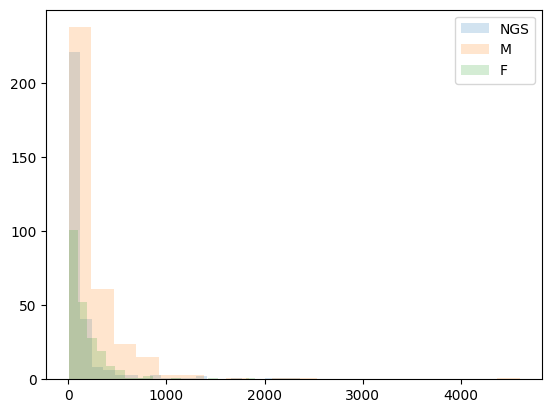

In [73]:
plt.hist(words_by_speaker[words_by_speaker.gender_speaker=='NGS'].spoken_word_count, bins=20, label='NGS', alpha=0.2)
plt.hist(words_by_speaker[words_by_speaker.gender_speaker=='M'].spoken_word_count, bins=20, label='M', alpha=0.2)
plt.hist(words_by_speaker[words_by_speaker.gender_speaker=='F'].spoken_word_count, bins=20, label='F', alpha=0.2)

plt.legend()
# plt.hist(speakers[speakers.gender_speaker=='NGS'].spoken_word_count, bins=20)
# plt.hist(speakers[speakers.gender_speaker=='M'].spoken_word_count, bins=20)
# plt.hist(speakers[speakers.gender_speaker=='F'].spoken_word_count, bins=20)


### More Bechdel:

In [74]:
_char_merge = characters.merge(
    speakers.groupby(['book', 'speaker_matched']).agg({'spoken_word_count':sum}).reset_index().rename(columns={'speaker_matched':'name'}),
    on=['book', 'name'],
    how='left'
)
_char_merge

,book,name,gender,human,alias_count,is_protagonist,is_mum,is_dad,is_granny,is_grandpa,spoken_word_count
0,Owl Babies,Sarah,F,NH,0,1,False,False,False,False,172.0
1,Owl Babies,Percy,M,NH,0,1,False,False,False,False,88.0
2,Owl Babies,Bill,M,NH,0,1,False,False,False,False,96.0
3,Where's My Teddy,Eddy,M,H,0,1,False,False,False,False,215.0
4,We're Going on a Bear Hunt,we,NGS,H,0,1,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1456,Jack and the Beanstalk,mother,F,H,0,0,True,False,False,False,84.0
1457,Jack and the Beanstalk,old man,M,H,0,0,False,False,False,False,216.0
1458,Jack and the Beanstalk,goose,F,NH,0,0,False,False,False,False,136.0
1459,Jack and the Beanstalk,giant,M,NH,0,0,False,False,False,False,154.0


In [75]:
_char_merge[_char_merge.gender=='F'].spoken_word_count.isna().sum()

130

In [76]:
_char_merge[_char_merge.gender=='M'].spoken_word_count.isna().sum()

214

In [77]:
_char_merge[_char_merge.gender=='NGS'].spoken_word_count.isna().sum()

396

In [78]:
MS = speakers.spoken_word_count.max()

In [79]:
MS

2360

In [170]:
[f/speech_book_count for f in _m_books][10]

0.22598870056497175

In [82]:
_thresh = []
_f_books = []
_m_books = []
_ngs_books = []

for threshold in range(0,MS,10):
    _thresh.append(threshold)
    _speakers = speakers[speakers.spoken_word_count>threshold]
    _f_books.append(
        len(_speakers[
            (_speakers.gender_speaker=='F')*(_speakers.gender_recipient=='F')
        ].book.unique())
    )
    _m_books.append(
        len(_speakers[
            (_speakers.gender_speaker=='M')*(_speakers.gender_recipient=='M')
        ].book.unique())
    )
    _ngs_books.append(
        len(_speakers[
            (_speakers.gender_speaker=='NGS')*(_speakers.gender_recipient=='NGS')
        ].book.unique())
    )

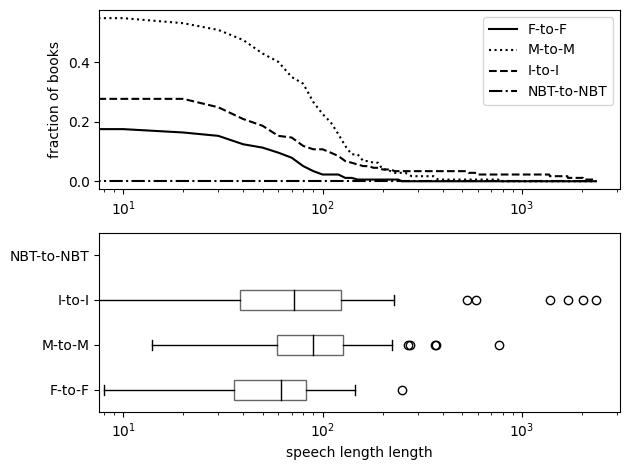

In [88]:
ax1 = plt.subplot(2,1,1)
plt.plot(_thresh, [f/speech_book_count for f in _f_books], label='F-to-F', linestyle='-', color='k')
plt.plot(_thresh, [f/speech_book_count for f in _m_books], label='M-to-M', linestyle=':', color='k')
plt.plot(_thresh, [f/speech_book_count for f in _ngs_books], label='I-to-I', linestyle='--', color='k')
plt.plot(_thresh, [0 for f in _ngs_books], label='NBT-to-NBT', linestyle='-.', color='k')
plt.legend()
plt.xscale('log')
# plt.xlabel('speech section length threshold')
plt.ylabel('fraction of books')

ax2 = plt.subplot(2,1,2, sharex=ax1)
bplot = plt.boxplot(
    [
        speakers[
            (speakers.gender_speaker=='F')*(speakers.gender_recipient=='F')
        ].groupby('book').agg({'spoken_word_count': max}).spoken_word_count,
        speakers[
            (speakers.gender_speaker=='M')*(speakers.gender_recipient=='M')
        ].groupby('book').agg({'spoken_word_count': max}).spoken_word_count,
        speakers[
            (speakers.gender_speaker=='NGS')*(speakers.gender_recipient=='NGS')
        ].groupby('book').agg({'spoken_word_count': max}).spoken_word_count,
        [0]
    ],
    showmeans=False,
    vert=False,
    patch_artist=True
);
for median in bplot['medians']:
    median.set_color('black')
# colours = ['blue', 'orange', 'green']
colours = ['white' for i in range(3)]
hatching = ['/', '.', '*']
for patch, color in zip(bplot['boxes'], colours):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
# for patch, hatch in zip(bplot['boxes'], hatching):
#     patch.set_hatch(hatch)
# #     h.set_hatch_linewidth(2)
    
plt.yticks([1,2,3,4], ['F-to-F', 'M-to-M', 'I-to-I', 'NBT-to-NBT'])
plt.xscale('log')
plt.xlabel('speech length length')
plt.tight_layout()
plt.savefig("bechdel_chapter_fig.png")

In [2]:
summary_character

NameError: name 'summary_character' is not defined

In [64]:
summary_character.loc[len(summary_character)] = 0

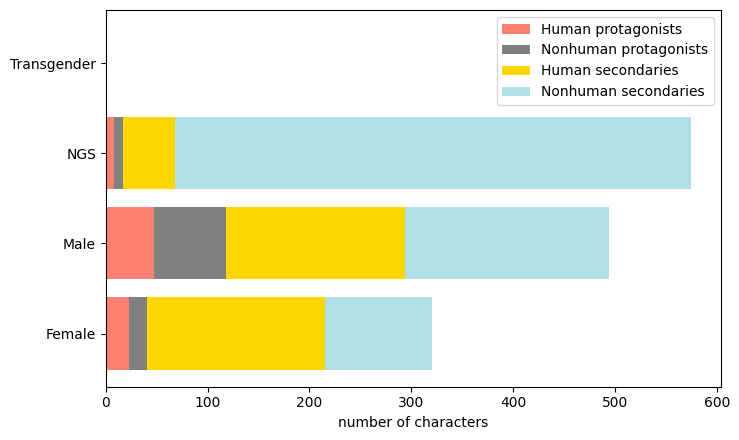

In [65]:
plt.rcParams["figure.figsize"] = [7.50, 4.50]
plt.rcParams["figure.autolayout"] = True

gender = ['Female', 'Male', 'NGS', 'Transgender']
human_protagonists = summary_character['human protagonists']
nonhuman_protagonists = summary_character['nonhuman protagonists']
human_secondaries = summary_character['human secondaries']
nonhuman_secondaries = summary_character['nonhuman secondaries']


b1 = plt.barh(gender, human_protagonists, color="salmon")
b2 = plt.barh(gender, nonhuman_protagonists, left=human_protagonists, color="grey")
b3 = plt.barh(gender, human_secondaries, left=human_protagonists + nonhuman_protagonists, color="gold")
b4 = plt.barh(gender, nonhuman_secondaries, left=human_protagonists + nonhuman_protagonists + human_secondaries, color="powderblue")


plt.legend([b1, b2, b3, b4], ["Human protagonists", "Nonhuman protagonists", "Human secondaries", "Nonhuman secondaries", ])#, title="Characters")#, loc="upper right")
plt.xlabel('number of characters')
plt.tight_layout()
plt.show()

In [1]:
colours = ['salmon', 'grey', 'gold', 'powderblue']
data = [human_protagonists, nonhuman_protagonists, human_secondaries, nonhuman_secondaries]
labels = ["Human protagonists", "Nonhuman protagonists", "Human secondaries", "Nonhuman secondaries"]
for i in range(4):
    plt.subplot(2, 2, i+ 1)
    plt.barh(gender, data[i], color=colours[i])
    
    if i > 1:
        plt.xlabel('number of characters')
    plt.title(labels[i])
    plt.tight_layout()

NameError: name 'human_protagonists' is not defined

In [76]:
speakers

,book,speech_section_id,speaker,recipient,speaker_matched,recipient_matched,speech_text,spoken_words_only,spoken_word_count,chunk_titles,...,human_recipient,alias_count_recipient,speaker_is_mum,speaker_is_dad,speaker_is_granny,speaker_is_grandpa,recipient_is_mum,recipient_is_dad,recipient_is_granny,recipient_is_grandpa
0,The Night Before Christmas,0,St. Nicholas,Reindeer,St. Nicholas,Reindeer,"""Now, Dasher! now, Dancer!\nnow, Prancer and V...","Now, Dasher! now, Dancer! now, Prancer and Vix...",183,The Night Before Christmas,...,NH,0.0,False,False,False,False,False,False,False,False
1,The Night Before Christmas,1,St. Nicholas,Everyone,St. Nicholas,Everyone,"""Happy\nChristmas to all, and to all a good\nn...","Happy Christmas to all, and to all a good night!",48,The Night Before Christmas,...,H,0.0,False,False,False,False,False,False,False,False
2,Sugarlump and the Unicorn,0,Sugarlump,himself,Sugarlump,Sugarlump,"""Here in the children's bedroom\nIs where I wa...",Here in the children's bedroom Is where I want...,106,Sugarlump and the Unicorn,...,NH,0.0,False,False,False,False,False,False,False,False
3,Sugarlump and the Unicorn,1,Sugarlump,himself,Sugarlump,Sugarlump,"""Oh to be out in the big wide world!\nI wish I...",Oh to be out in the big wide world! I wish I c...,56,Sugarlump and the Unicorn,...,NH,0.0,False,False,False,False,False,False,False,False
4,Sugarlump and the Unicorn,2,unicorn,Sugarlump,unicorn,Sugarlump,"""Done!"" came a voice, and there stood a beast\...",Done! I can grant horses' wishes.,33,Sugarlump and the Unicorn,...,NH,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,How The Grinch Stole Christmas,4,Grinch,Himself,Grinch,Grinch,All I need is a reindeer...,All I need is a reindeer...,27,How The Grinch Stole Christmas,...,NH,0.0,False,False,False,False,False,False,False,False
3909,How The Grinch Stole Christmas,5,Grinch,Himself,Grinch,Grinch,"If I can't find a reindeer, I'll make one inst...","If I can't find a reindeer, I'll make one inst...",50,How The Grinch Stole Christmas,...,NH,0.0,False,False,False,False,False,False,False,False
3910,How The Grinch Stole Christmas,6,Grinch,Max (the dog),Grinch,Max,Giddap!,Giddap!,7,How The Grinch Stole Christmas,...,NH,0.0,False,False,False,False,False,False,False,False
3911,How The Grinch Stole Christmas,7,Grinch,Himself,Grinch,Grinch,"This is stop number one, the old Grinchy Claus...",This is stop number one.,24,How The Grinch Stole Christmas,...,NH,0.0,False,False,False,False,False,False,False,False


In [428]:
speakers[speakers.speaker_is_mum].spoken_word_count.sum() / speakers[speakers.gender_speaker=='F'].spoken_word_count.sum()

0.09888958726168029

In [429]:
speakers[speakers.speaker_is_dad].spoken_word_count.sum() / speakers[speakers.gender_speaker=='M'].spoken_word_count.sum()

0.0200529701097238


#### Protagonists only:

In [62]:
merged = speakers.merge(characters, how='left', left_on=['book', 'name_speaker'], right_on=['book', 'name'])

In [78]:
merged = merged[merged.is_protagonist == 1]

In [79]:
spoken_word_count = {
    G: sum([len(text.split()) for text in merged[merged.gender_speaker==G].spoken_words_only])
    for G in ['F', 'M', 'NGS']
}


In [80]:
received_word_count = {
    G: sum([len(text.split()) for text in merged[merged.gender_recipient==G].spoken_words_only])
    for G in ['F', 'M', 'NGS']
}


In [81]:
spoken_word_count

{'F': 2335, 'M': 9874, 'NGS': 1134}

In [82]:
received_word_count

{'F': 3210, 'M': 5166, 'NGS': 4538}

In [83]:
len(merged[merged.gender_recipient=='F'].book.unique())

77

In [84]:
speaker_book_count = {
    G: len(merged[
        (merged.gender_speaker==G)*(merged.gender_recipient==G)
    ].book.unique())
    for G in ['F', 'M', 'NGS']
}


In [85]:
speaker_book_count

{'F': 18, 'M': 76, 'NGS': 7}

In [86]:
received_book_count = {
    G: len(merged[merged.gender_recipient==G].book.unique())
    for G in ['F', 'M', 'NGS']
}


In [87]:
received_book_count

{'F': 77, 'M': 100, 'NGS': 84}

In [88]:
speech_book_count = len(merged.book.unique())

In [89]:
speech_book_count

144

In [90]:
gender_count = {
    G: sum([1 for g,p in zip(characters.gender, characters.is_protagonist) if g==G and p==1])
    for G in ['F', 'M', 'NGS']
}

In [91]:
summary_speech = pd.DataFrame({
    'gender': spoken_word_count.keys(),
    'total_spoken_words': spoken_word_count.values(),
    'proportion_speech': [v / sum(spoken_word_count.values()) for v in spoken_word_count.values()],
    'words_spoken_per_character': [v / c for v,c in zip(spoken_word_count.values(), gender_count.values())],
    'words_received_per_character': [v / c for v,c in zip(received_word_count.values(), gender_count.values())],
    'bechdel_books': speaker_book_count.values(),
    'bechdel_proportions': [v / speech_book_count for v in speaker_book_count.values()],
    'total_received_words': received_word_count.values(),
    'received_proportion_speech': [v / sum(received_word_count.values()) for v in received_word_count.values()],
    
#     'human proportions': [v / sum(characters.human=='H') for v in human_count.values()],
#     'nonhuman characters': nonhuman_count.values(),
#     'nonhuman proportions': [v / sum(characters.human=='NH') for v in nonhuman_count.values()],
#     'protagonists': protagonist_count.values(),
#     'protagonist proportions': [v / sum(characters.is_protagonist==1) for v in protagonist_count.values()],
#     'secondaries': secondary_count.values(),
#     'secondary proportions': [v / sum(characters.is_protagonist==0) for v in secondary_count.values()],
})

In [92]:
summary_speech

,gender,total_spoken_words,proportion_speech,words_spoken_per_character,words_received_per_character,bechdel_books,bechdel_proportions,total_received_words,received_proportion_speech
0,F,2335,0.174998,53.068182,72.954545,18,0.125000,3210,0.248567
1,M,9874,0.740013,69.535211,36.380282,76,0.527778,5166,0.400031
2,NGS,1134,0.084988,54.000000,216.095238,7,0.048611,4538,0.351402


In [629]:
gender_count[]

{'F': 44, 'M': 142, 'NGS': 21}

In [630]:
60/85

0.7058823529411765

In [93]:
53/69.5

0.762589928057554